In [72]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import math
import seaborn as sns
import pylab
import plotnine as pn
import matplotlib.pyplot as plt
%matplotlib inline

## **Однофакторный дисперсионный анализ**

Для проведения однофакторного дисперсионного анализа был взят датасет под названием [Video Game Sales with Ratings](https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings). 

В датасете имеются следующие поля:

* Name
* Platform
* YearofRelease
* Genre
* Publisher
* NASales
* EUSales
* JPSales
* OtherSales
* Global_Sales
* Critic_score - Aggregate score compiled by Metacritic staff
* Criticcount - The number of critics used in coming up with the Criticscore
* User_score - Score by Metacritic's subscribers
* Usercount - Number of users who gave the userscore
* Developer - Party responsible for creating the game
* Rating - The ESRB ratings

Исходя из представленных данных можно проанализировать, влияет ли жанр на продажи видеоигр. Для анализа возьмем данные продаж по всему миру - **Global_Sales**.

In [73]:
# Загрузим датасет

df = pd.read_csv("/content/Video_Games_Sales_as_at_22_Dec_2016.csv")

In [74]:
# Просмотрим датасет

df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
# Просмотрим значения описательной статистики

df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,16450.000000,16719.000000,16719.000000,16719.000000,16719.000000,16719.000000,8137.000000,8137.000000,7590.000000
mean,2006.487356,0.263330,0.145025,0.077602,0.047332,0.533543,68.967679,26.360821,162.229908
std,5.878995,0.813514,0.503283,0.308818,0.186710,1.547935,13.938165,18.980495,561.282326
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,10665.000000


Значения описательной статистики представлены только по числовым признакам. Мы можем увидеть, что количество измерений по всем играм равно **16719**. 

В признаке **Global_Sales** пропуски отсутствуют. 

Среднее арифметическое значение равно **0.53**. 

Среднее квадратическое отклонение равно **1.54**.

Среди значений присутствуют выбрасы, так как максимальное значение равно **82.53**, притом что 75% значений ниже **0.47**.



In [76]:
# Создадим датафрейм с жанрами, выпускающими компаниями и продажами по всему миру

gps = df[['Genre', 'Publisher',	'Global_Sales']].copy()
gps.head()

,Genre,Publisher,Global_Sales
0,Sports,Nintendo,82.53
1,Platform,Nintendo,40.24
2,Racing,Nintendo,35.52
3,Sports,Nintendo,32.77
4,Role-Playing,Nintendo,31.37


In [77]:
# Посчитаем пропуски

gps.isna().sum()

Genre            2
Publisher       54
Global_Sales     0
dtype: int64

In [78]:
# Посмотрим, к какой выпускающей компании принадлежат пропуски по жанрам

gps.loc[gps['Genre'].isnull()]

,Genre,Publisher,Global_Sales
659,NaN,Acclaim Entertainment,2.39
14246,NaN,Acclaim Entertainment,0.03


In [79]:
# Самым частым жанром для компании Acclaim Entertainment является Sports

gps.loc[gps['Publisher'] == 'Acclaim Entertainment']['Genre'].value_counts()

Sports          52
Racing          44
Fighting        31
Shooter         17
Action          14
Puzzle           9
Platform         5
Misc             5
Adventure        4
Strategy         2
Role-Playing     1
Name: Genre, dtype: int64

In [80]:
# Заменим пропуски в жанре на Sports

gps.loc[gps['Genre'].isnull(), 'Genre'] = 'Sports'

In [81]:
# Проверим, что пропуски заполнены

gps.isna().sum()

Genre            0
Publisher       54
Global_Sales     0
dtype: int64

In [82]:
# Посчитаем количество жанров всего

genre_list = list(set(gps['Genre']))
len(genre_list)

12

In [83]:
# Посмотрим количество измерений по жанрам

gps['Genre'].value_counts()

Action          3370
Sports          2350
Misc            1750
Role-Playing    1500
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       874
Fighting         849
Strategy         683
Puzzle           580
Name: Genre, dtype: int64

### **Проверка условий для дисперсионного анализа:**

1. Одинаковое количество измерений.
2. Выборки независимы.
3. Значения следуют нормальному распределению.
4. Дисперсии однородны.

### **1. Определение количества измерений.**

Возьмем наименьшее количество измерений среди жанров, в данном случае это жанр Puzzle $\textbf{(n = 580)}$.

Сформируем выборки по остальным жанрам.

In [94]:
# Выберем случайным образом измерения по всем жанрам, n=580

gps_genre_sample = pd.DataFrame(columns=['Genre',	'Publisher',	'Global_Sales'])
for item in range(len(genre_list)):
  gps_genre_sample = gps_genre_sample.append(gps.loc[gps['Genre'] == genre_list[item]].sample(n=580, random_state=1))

gps_genre_sample.head()

,Genre,Publisher,Global_Sales
12503,Strategy,Namco Bandai Games,0.06
1597,Strategy,Atari,1.25
6829,Strategy,Sega,0.24
2829,Strategy,Sega,0.72
11158,Strategy,Tecmo Koei,0.09


In [100]:
# Функция для извлечения данных продаж по жанрам, возвращяет словарь

def sales_by_genre(dataframe, genre_list):
  sales_by_genre_dict = {}
  for item in range(len(genre_list)):
    sales_by_genre_dict[genre_list[item]] = list(gps_genre_sample.loc[dataframe['Genre'] == genre_list[item]]['Global_Sales'])
  return sales_by_genre_dict

In [102]:
# Просмотрим ключи-жанры

sales_by_genre(gps, genre_list).keys()

dict_keys(['Strategy', 'Role-Playing', 'Puzzle', 'Shooter', 'Simulation', 'Sports', 'Racing', 'Action', 'Adventure', 'Misc', 'Platform', 'Fighting'])

In [104]:
# Проверим, что количество измерений в выборках одинаковое

for item in range(len(genre_list)):
    print(len(sales_by_genre(gps, genre_list).get(genre_list[item])))

580
580
580
580
580
580
580
580
580
580
580
580


### **2. Проверка на независимость выборок.**

Выборки являются **независимыми**, так как относятся к различным измерениям для одной групповой переменной (жанры), следовательно закономерное и однозначное соответствие между выборками невозможно.

### **3. Проверка на нормальность распределения значений в выборках.**

Проверим данные подгрупп на нормальность распределения. Составим гипотизы.

$H0$: Распределение нормальное.

$H1$: Распределение не соответствует нормальному.

Воспользуемся критерием Шапиро-Уилка. Статистическую значимость возьмем $\textbf{0.05}$.

In [105]:
# Проверим гипотизу H0

alpha = 0.05
gps_genre_p = []
print('Гипотеза H0: 0\nГипотеза H1: 1\n')
for item in range(len(genre_list)):
  p = stats.shapiro(sales_by_genre(gps, genre_list).get(genre_list[item]))[1]
  gps_genre_p.append(p)
  if p > alpha:
    print(f'0: {genre_list[item]}')
  else:
    print(f'1: {genre_list[item]}')

Гипотеза H0: 0
Гипотеза H1: 1

1: Strategy
1: Role-Playing
1: Puzzle
1: Shooter
1: Simulation
1: Sports
1: Racing
1: Action
1: Adventure
1: Misc
1: Platform
1: Fighting


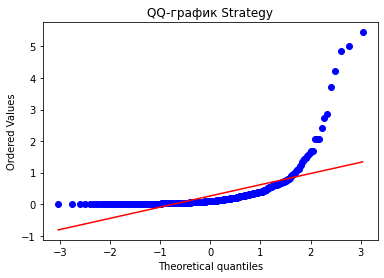

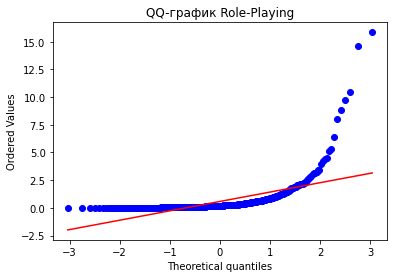

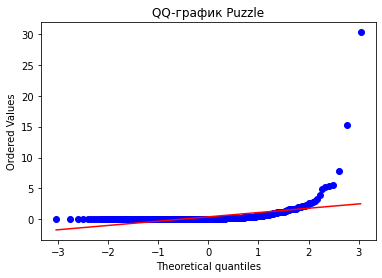

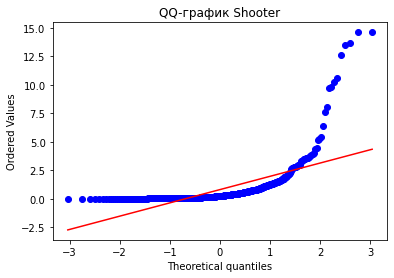

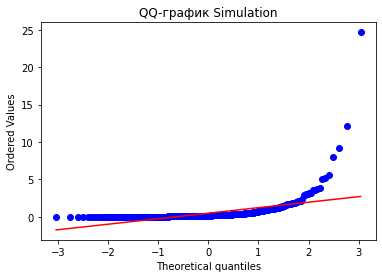

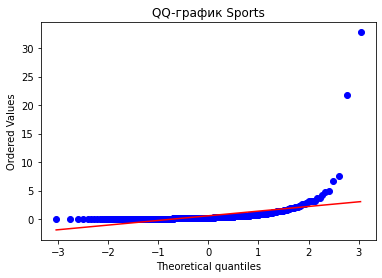

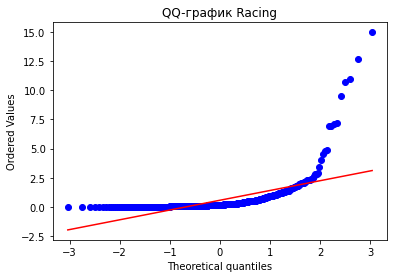

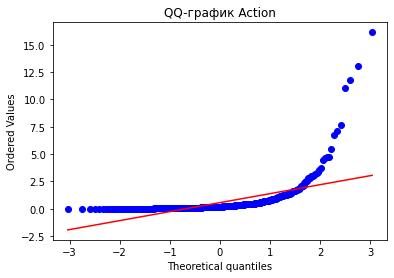

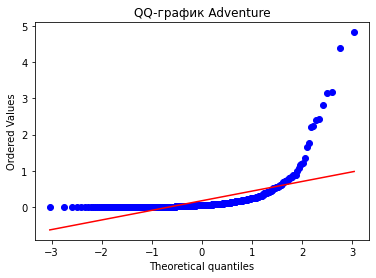

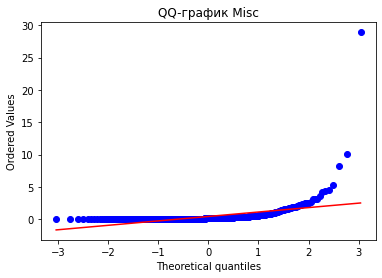

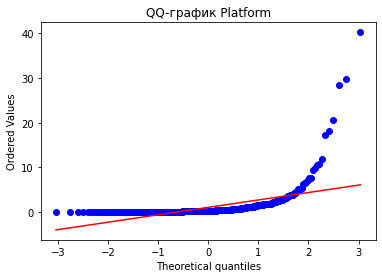

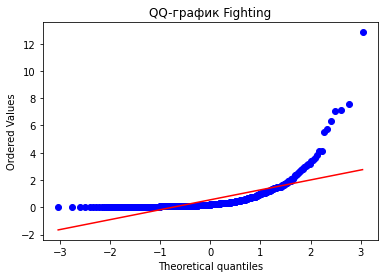

In [106]:
# Убедимся в ненормальности распределения с помощью QQ-графиков

for item in range(len(genre_list)):
  x_exp = sales_by_genre(gps, genre_list).get(genre_list[item])
  stats.probplot(x_exp, dist='norm', plot=pylab)
  plt.title(f'QQ-график {genre_list[item]}')
  plt.show()

**Вывод:** данные подгрупп не имеют нормального распределения. Следовательно для проведения дисперсионного анализа вместо z/t-критериев мы можем использовать критерий Манна-Уитни.

### **4. Проверка на однородность дисперсий.**

Так как данные подгрупп не имеют нормального распределения для провеки однородности дисперсий воспользуемся критерием Кохрена. Составим гипотизы.

$H0: σ_1^2 = σ_2^2 = ... = σ_{12}^2 = σ^2$

$H1: σ_{max}^2 > σ^2$

Статистическую значимость возьмем $\textbf{0.05}$.

Все $12$ выборок по жанрам имеют одинаковый объем измерений, что также удовлетворяет допущениям критерия Кохрена.

Табличное значение этого критерия для уровня значимости $α = 0.05$, при числе степеней свободы для каждой из дисперсий $m = 580-1 = 579$ и числе сравниваемых дисперсий $k = 12$, равно $G_{0.05;\ 579;\ 12}=\textbf{0.0833}$.

In [107]:
# Проверим однородность дисперсий по критерию Кохрена

g_table = 0.0833
d_list = []
for item in range(len(genre_list)):
  d_list.append(np.var(sales_by_genre(gps, genre_list).get(genre_list[item]), ddof=1))
d_list.sort(reverse=True)
g = d_list[0]/sum(d_list)

if g < g_table:
  print(f'Принимаем гипотезу H0.\nG = {g}')
else:
  print(f'Принимаем гипотезу H1.\nG = {g}')

Принимаем гипотезу H1.
G = 0.3151098083353864


**Вывод:** так как расчетное $G$ больше табличного $G_{α;m;k}$, отклонение дисперсии $\sigma_{max}^2 = 9.115$ от остальных следует (с вероятностью 0.95) признать существенным, и, следовательно, все дисперсии не являются однородными (т.е. разбросы в измерениях всех 12 жанров разные).

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


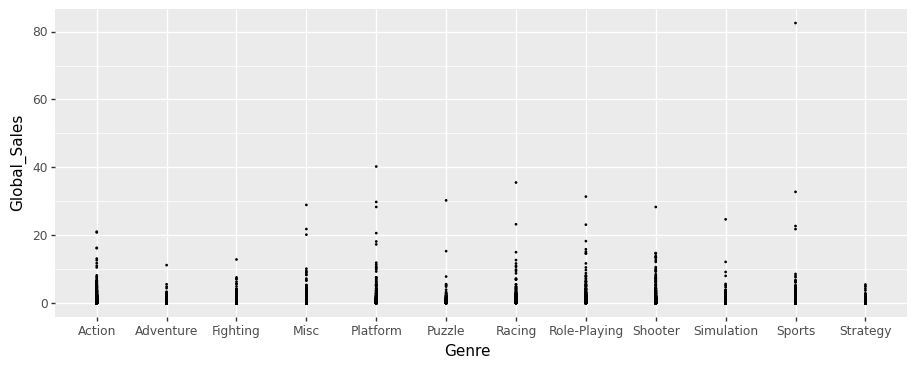

<ggplot: (8731150141893)>

In [110]:
# Посмотрим на разброс значений

pn.options.figure_size = (11, 4)
pn.ggplot(gps) + pn.aes(x="Genre", y="Global_Sales", size='pop') + pn.geom_point(size=0.1)

### **Итоговый вывод**

Исследовав данные продаж видеоигр **Global_Sales** по признаку **Genre**, мы выяснили, что их распределение не является нормальным, а дисперсии неоднородны. 

В связи с чем применение дисперсионного анализа для выяления влияния признака "Genre" на продажи некорректно, необходимо попробовать улучшить данные через логарифмирование или использовать другие методы, например линейную регрессию.